Python class

    class Simulator(object):
        def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
            self.amplitude = amplitude
            self.yrange = yrange

            self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])

            # Load/generate data files
            self.sample_rate_Hz = 44100
            fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
            assert(fs == self.sample_rate_Hz)
            self.x_prbs20 = self.amplitude * x/(2**15)

            t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
            self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")

        def vcf(self, x, cutoff, resonance):
            # Example filter
            b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
            return signal.lfilter(b, a, x)

        def simulate_chirp(self, cutoff, resonance):
            y = self.vcf(self.x_chirp, cutoff, resonance)

            f = linspace(20, 20e3, len(y))
            #H = 1/self.amplitude * y
            H = 1/self.amplitude * signal.hilbert(y)

            label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
            self.plot_frequency_response(f, H, label=label)
            return 

        def simulate_prbs(self, cutoff, resonance, h_length=None):
            x = self.x_prbs20
            y = self.vcf(x, cutoff, resonance)

            if h_length is None:
                h_length = int(30/cutoff)

            t, h, f, H = self.analyze_prbs(x, y, h_length)
            label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
            self.plot_frequency_response(f, H, label=label)

        def analyze_prbs(self, x, y, h_length):
            # Estimate impulse response using a pseudo-random bit sequence.
            h = signal.correlate(y, x, "full")
            h = h[len(h)//2:]

            # Limit the impulse response length to lower the noise
            h = h[0:h_length]
            t = arange(h_length)/self.sample_rate_Hz

            # Estimate frequency response
            H = fft.fft(h)
            H = H[0:len(H)//2] 
            H /= max(abs(H))
            f = linspace(0.01, self.sample_rate_Hz/2, len(H))

            return t, h, f, H

        def plot_frequency_response(self, f, H, label=None):
            self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

        def show(self):
            # Frequency response graph
            self.ax1.grid(True, "both", "both")
            self.ax1.legend()
            self.ax1.set_xlim(20, 20e3)
            self.ax1.set_ylim(*self.yrange)

            self.fig.tight_layout()
            #self.fig.show()


In [1]:
using Plots
using DSP

In [33]:
# Generate a chirp
function chirp(t, f0, f1)
    f = collect(range(f0, stop=f1, length=length(t)))
    x = @. sin(2pi* f * t)
end

fs = 44100
t = collect(range(0, stop=1, step=1/fs))
x = chirp(t, 20, 20e3)
;

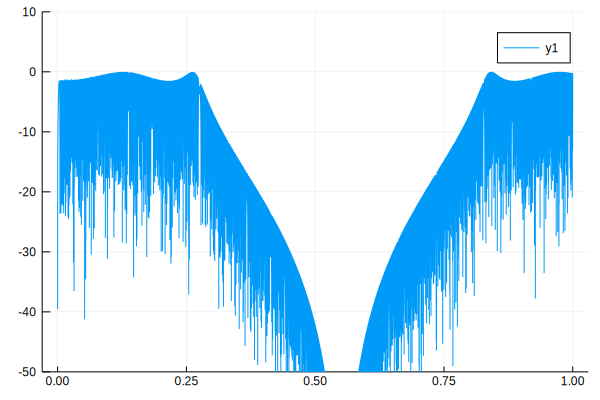

In [51]:
# Apply filter
flt = digitalfilter(Lowpass(0.5), Chebyshev1(4, 3))
y = filt(flt, x)
plot(t, @. 10*log10(abs(y)))
plot!(ylims = (-50, 10))

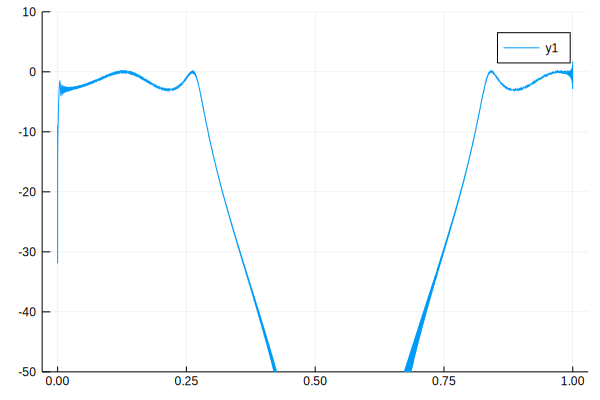

In [52]:
# Hilbert transform the chirp
H = hilbert(y)
plot(t, @. 20*log10(abs(H)))
plot!(ylims = (-50, 10))